### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import pandas_datareader as pdr

In [2]:
key = ''
df = pdr.get_data_tiingo('AAPL',api_key=key)


C:\Python39\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [3]:
df.to_csv('AAPL.csv')

In [4]:
import pandas as pd
df = pd.read_csv('AAPL.csv')

In [5]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-12-13 00:00:00+00:00,115.19,115.92,113.750,113.84,43733811,27.103308,27.275071,26.764487,26.785664,174935244,0.0,1.0
1,AAPL,2016-12-14 00:00:00+00:00,115.19,116.20,114.980,115.04,34031834,27.103308,27.340953,27.053897,27.068014,136127336,0.0,1.0
2,AAPL,2016-12-15 00:00:00+00:00,115.82,116.73,115.230,115.38,46524544,27.251542,27.465658,27.112720,27.148014,186098176,0.0,1.0
3,AAPL,2016-12-16 00:00:00+00:00,115.97,116.50,115.645,116.47,44351134,27.286836,27.411541,27.210366,27.404482,177404536,0.0,1.0
4,AAPL,2016-12-19 00:00:00+00:00,116.64,117.38,115.750,115.80,27779423,27.444482,27.618598,27.235072,27.246836,111117692,0.0,1.0


In [6]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2021-12-06 00:00:00+00:00,165.32,167.8799,164.28,164.290,107496982,165.32,167.8799,164.28,164.290,107496982,0.0,1.0
1254,AAPL,2021-12-07 00:00:00+00:00,171.18,171.5800,168.34,169.080,120405352,171.18,171.5800,168.34,169.080,120405352,0.0,1.0
1255,AAPL,2021-12-08 00:00:00+00:00,175.08,175.9600,170.70,172.125,116998901,175.08,175.9600,170.70,172.125,116998901,0.0,1.0
1256,AAPL,2021-12-09 00:00:00+00:00,174.56,176.7500,173.92,174.910,108923739,174.56,176.7500,173.92,174.910,108923739,0.0,1.0
1257,AAPL,2021-12-10 00:00:00+00:00,179.45,179.6300,174.69,175.205,115402731,179.45,179.6300,174.69,175.205,115402731,0.0,1.0


In [8]:
df1 = df.reset_index()['close']

In [9]:
df1.shape

(1258,)

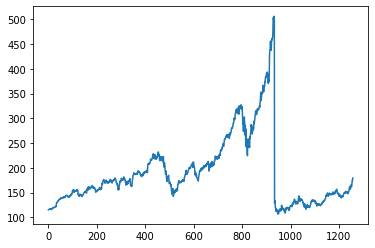

In [10]:
import matplotlib.pyplot  as plt
plt.plot(df1)

#### LSTM are sensitive to the scale of the data so we apply MinMaxScaler

In [12]:
df1.shape

(1258, 1)

In [11]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))


In [13]:
df1

array([[0.02091421],
       [0.02091421],
       [0.02249217],
       ...,
       [0.17092048],
       [0.16961803],
       [0.181866  ]])

Whenever we have time series kind of data the next data is always dependent on past data
So train test split using cross validation or random seed works good in regression or classification problem but not here

So taking 1st 65% data as train size and rest as test

In [20]:
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size,:], df1[training_size:len(df1),:]

In [21]:
training_size,test_size

(817, 441)

In [22]:
test_data

array([[3.39060739e-01],
       [3.65735755e-01],
       [3.50231684e-01],
       [3.45497808e-01],
       [3.06574828e-01],
       [2.94376957e-01],
       [3.50757671e-01],
       [3.47351284e-01],
       [3.79711960e-01],
       [3.52911709e-01],
       [3.70619912e-01],
       [3.69317470e-01],
       [3.35804634e-01],
       [3.45873513e-01],
       [3.37056982e-01],
       [3.89805886e-01],
       [3.82191609e-01],
       [3.98822793e-01],
       [4.03631810e-01],
       [4.16806512e-01],
       [4.51371321e-01],
       [4.44809017e-01],
       [4.50469631e-01],
       [4.40726362e-01],
       [4.26023795e-01],
       [4.04583594e-01],
       [4.23944897e-01],
       [4.21264872e-01],
       [4.41152160e-01],
       [4.41653100e-01],
       [4.30156544e-01],
       [4.53074515e-01],
       [4.68278021e-01],
       [4.56430808e-01],
       [4.66675016e-01],
       [4.77695679e-01],
       [4.85385097e-01],
       [4.93174703e-01],
       [5.09179712e-01],
       [5.21402630e-01],


#### We r taking a time step to consider how many previous days' result to affect today's result

In [23]:
import numpy
#convert an array of values into a dataset matrix
def create_dataset(dataset,time_step=1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-1-time_step):
        a = dataset[i:(i+time_step),0]    ### i=0 :  0,1,2,3,...,99   100
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return numpy.array(dataX), numpy.array(dataY)

In [24]:
time_step=100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [26]:
print(X_train.shape, y_train.shape)

(716, 100) (716,)


In [27]:
print(X_test.shape, y_test.shape)

(340, 100) (340,)


In [28]:
## we have to give LSTMinput in 3d
# so reshaping input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [30]:
#Create Stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [31]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
12/12 [==============================] - 8s 295ms/step - loss: 0.0187 - val_loss: 0.0219
Epoch 2/10
12/12 [==============================] - 2s 177ms/step - loss: 0.0034 - val_loss: 0.0245
Epoch 3/10
12/12 [==============================] - 2s 176ms/step - loss: 0.0012 - val_loss: 0.0260
Epoch 4/10
12/12 [==============================] - 2s 174ms/step - loss: 8.4049e-04 - val_loss: 0.0250
Epoch 5/10
12/12 [==============================] - 3s 238ms/step - loss: 8.2164e-04 - val_loss: 0.0211
Epoch 6/10
12/12 [==============================] - 3s 243ms/step - loss: 7.8771e-04 - val_loss: 0.0220
Epoch 7/10
12/12 [==============================] - 3s 227ms/step - loss: 6.9039e-04 - val_loss: 0.0231
Epoch 8/10
12/12 [==============================] - 3s 226ms/step - loss: 6.6522e-04 - val_loss: 0.0210
Epoch 9/10
12/12 [==============================] - 3s 225ms/step - loss: 6.2980e-04 - val_loss: 0.0201
Epoch 10/10
12/12 [==============================] - 3s 228ms/step - loss: 6

In [34]:
## Predictions 

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


In [35]:
#Transform to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [36]:
#calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

199.0045332964474

In [37]:
#Test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

178.93523756975907

#### Plotting

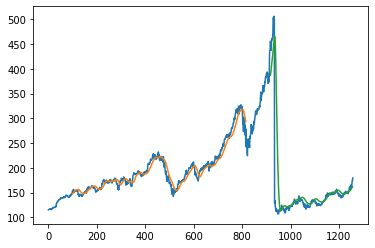

In [39]:
#shift train predictions for plotting
look_back = 100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, : ] = train_predict

#shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

#plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [40]:
len(test_data)

441

In [41]:
#we need last 100 days data
x_input = test_data[341:].reshape(1,-1)
x_input.shape 

(1, 100)

In [42]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

### prediction of upcoming days

In [43]:
from numpy import array
lst_output = []

n_steps = 100
i = 0

#today's o/p will act as i/p for upcoming day
#and we have to remove last 100th day from input every day

while (i<30):
    
    if (len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(-1,1)
        x_input = x_input.reshape((1,n_steps,1))
        
        yhat = model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_nput = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.14295383]
101
1 day input [0.10449593 0.10557295 0.10001252 0.09552912 0.09718222 0.09773325
 0.09688165 0.10149029 0.10046337 0.10073889 0.09843456 0.09830933
 0.09708203 0.09773325 0.10532248 0.10584847 0.11090795 0.10857858
 0.0989856  0.09983719 0.10356919 0.10737633 0.10715091 0.10399499
 0.10194114 0.10459612 0.11591735 0.11268629 0.11438948 0.11724483
 0.11887289 0.12485911 0.12090169 0.11829681 0.10552286 0.10697558
 0.10339386 0.10567314 0.10507201 0.09823419 0.09041954 0.09164684
 0.0977082  0.10016281 0.10038823 0.09650595 0.0878397  0.09014402
 0.08681277 0.08969317 0.08090169 0.08583594 0.08806512 0.09129618
 0.09031935 0.09009393 0.08683782 0.085335   0.09247339 0.09517846
 0.09946149 0.10499687 0.10624922 0.10680025 0.10482154 0.10469631
 0.1063995  0.10522229 0.11453976 0.10760175 0.10549781 0.10815279
 0.11183469 0.1105072  0.1113087  0.10920476 0.1101315  0.10289292
 0.10276769 0.10807765 0.10810269 0.11060739 0.11684408 0.12781465
 0.13452724 0.13570445 0.13668128

In [44]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [45]:
import matplotlib.pyplot as plt

In [47]:
df3 = df1.tolist()
df3.extend(lst_output)

In [49]:
len(df1)

1258

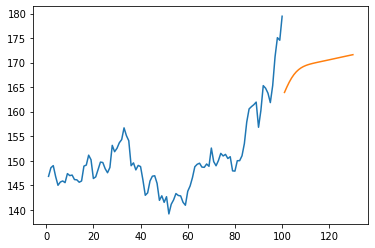

In [48]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))  #prev 100 data
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [50]:
len(df3)

1288

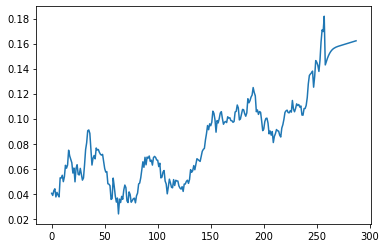

In [51]:
plt.plot(df3[1000:])